In [1]:
import math
import torch
import gpytorch
import tqdm
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 

In [29]:
train_x = torch.stack([torch.linspace(0, 1, 100),
torch.linspace(0, 2, 100)
],-1)
train_x1 = torch.linspace(0, 1, 100)

print(0)
train_y = torch.stack([
    torch.sin(train_x1 * (2 * math.pi)) + torch.randn(train_x1.size()) * 0.2,
    torch.cos(train_x1 * (2 * math.pi)) + torch.randn(train_x1.size()) * 0.2,
    torch.sin(train_x1 * (2 * math.pi)) + 2 * torch.cos(train_x1 * (2 * math.pi)) + torch.randn(train_x1.size()) * 0.2,
    -torch.cos(train_x1 * (2 * math.pi)) + torch.randn(train_x1.size()) * 0.2,
], -1)

print(train_x.shape, train_y.shape)

0
torch.Size([100, 2]) torch.Size([100, 4])


In [31]:
num_latents = 3
num_tasks = 4

class MultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self):
        # Let's use a different set of inducing points for each latent function
        inducing_points = torch.rand(num_latents, 16, 2)

        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each task
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
        )

        # We have to wrap the VariationalStrategy in a LMCVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=4,
            num_latents=3,
            latent_dim=-1
        )

        super().__init__(variational_strategy)

        # The mean and covariance modules should be marked as batch
        # so we learn a different set of hyperparameters
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])),
            batch_shape=torch.Size([num_latents])
        )

    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        # print(0)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


model = MultitaskGPModel()
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks)


In [32]:
likelihood(model(train_x)).rsample().shape

torch.Size([100, 4])

In [10]:
# class IndependentMultitaskGPModel(gpytorch.models.ApproximateGP):
#     def __init__(self):
#         # Let's use a different set of inducing points for each task
#         inducing_points = torch.rand(num_tasks, 16, 1)

#         # We have to mark the CholeskyVariationalDistribution as batch
#         # so that we learn a variational distribution for each task
#         variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
#             inducing_points.size(-2), batch_shape=torch.Size([num_tasks])
#         )

#         variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
#             gpytorch.variational.VariationalStrategy(
#                 self, inducing_points, variational_distribution, learn_inducing_locations=True
#             ),
#             num_tasks=2,
#         )

#         super().__init__(variational_strategy)

#         # The mean and covariance modules should be marked as batch
#         # so we learn a different set of hyperparameters
#         self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_tasks]))
#         self.covar_module = gpytorch.kernels.ScaleKernel(
#             gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_tasks])),
#             batch_shape=torch.Size([num_tasks])
#         )

#     def forward(self, x):
#         # The forward function should be written as if we were dealing with each output
#         # dimension in batch
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [19]:
# output = model(train_x)
# print(output.__class__.__name__, output.event_shape)

In [33]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
num_epochs = 1 if smoke_test else 100


model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.1)

# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

# We use more CG iterations here because the preconditioner introduced in the NeurIPS paper seems to be less
# effective for VI.
epochs_iter = tqdm.tqdm_notebook(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    epochs_iter.set_postfix(loss=loss.item())
    loss.backward()
    optimizer.step()

/tmp/ipykernel_898132/894135782.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  epochs_iter = tqdm.tqdm_notebook(range(num_epochs), desc="Epoch")


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([51, 2])


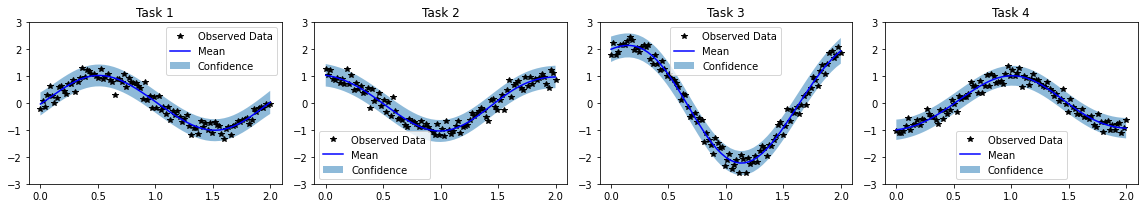

In [35]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
fig, axs = plt.subplots(1, num_tasks, figsize=(4 * num_tasks, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.stack([ torch.linspace(0, 1, 51),
    torch.linspace(0, 2, 51)],-1)
    print(test_x.shape)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

for task, ax in enumerate(axs):
    # Plot training data as black stars
    ax.plot(train_x[:,1].detach().numpy(), train_y[:, task].detach().numpy(), 'k*')
    # Predictive mean as blue line
    ax.plot(test_x[:,1].numpy(), mean[:, task].numpy(), 'b')
    # Shade in confidence
    ax.fill_between(test_x[:,1].numpy(), lower[:, task].numpy(), upper[:, task].numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(f'Task {task + 1}')

fig.tight_layout()
None